#Smart Diet Plan Recommendation System Using Fuzzy Logic with Genetic Algorithm

##**Data Preprocessing**##

In [76]:
!pip install streamlit

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [78]:
# Load the dataset
file_path = "/content/drive/MyDrive/Dataset/meal.csv"
meals_df = pd.read_csv(file_path)

In [79]:
# Explicitly remove detailed nutrient columns
meals_df.drop(columns=[
    'Calcium_mg', 'Iron_mg', 'Potassium_mg', 'VitC_mg', 'VitA_ug', 'VitB12_ug', 'Magnesium_mg', 'Weight_kg', 'Height_cm', 'Veg', 'Food_Category', 'Diet_Recommendation'
], inplace=True, errors='ignore')

# Select core nutrient columns only
num_cols = ["Calories", "Protein_g", "Carbohydrate_g", "Fat_g", "Fiber_g"]
meals_df[num_cols] = meals_df[num_cols].apply(pd.to_numeric, errors="coerce")

# Drop rows with missing values in selected columns
meals_df.dropna(subset=num_cols, inplace=True)
meals_df.reset_index(drop=True, inplace=True)

In [80]:
print(meals_df)

     Meal_ID                       Meal_Name  Calories  Protein_g  \
0          1  Whole Grain Waffles with Fruit       450         15   
1          2         Oven-Baked Falafel Wrap       320         10   
2          3               Avocado Rice Bowl       350         12   
3          4                 Vegan Jambalaya       450         15   
4          5            Eggplant Tomato Bake       320         10   
..       ...                             ...       ...        ...   
495      496       Barley with Mixed Veggies       350         12   
496      497             Chickpea Power Bowl       350         12   
497      498            Baked Oats with Pear       250          8   
498      499       Hummus with Carrot Sticks       450         15   
499      500       Roasted Cauliflower Tacos       400         35   

     Carbohydrate_g  Fat_g  Fiber_g  Age   BMI  Disease_Type Activity_Level  
0                55     12       10   43  23.7      Diabetes       Moderate  
1              

###**Correlation HeatMap**

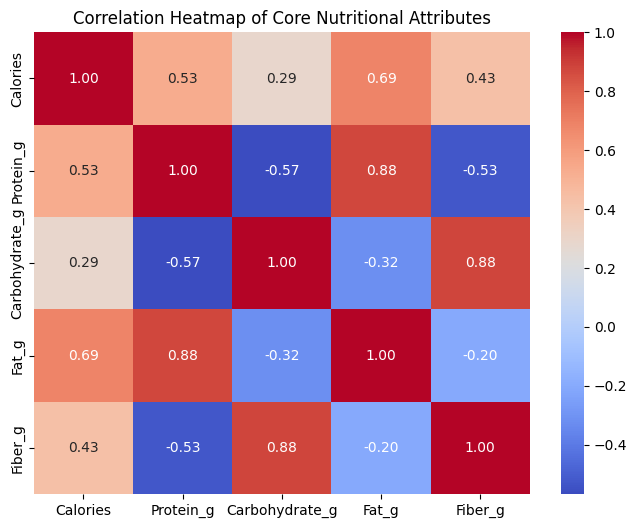

In [81]:
# Standard scale the selected columns
scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(meals_df[num_cols]), columns=num_cols)

# Correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(scaled_data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Core Nutritional Attributes")
plt.show()

###**Boxplot**

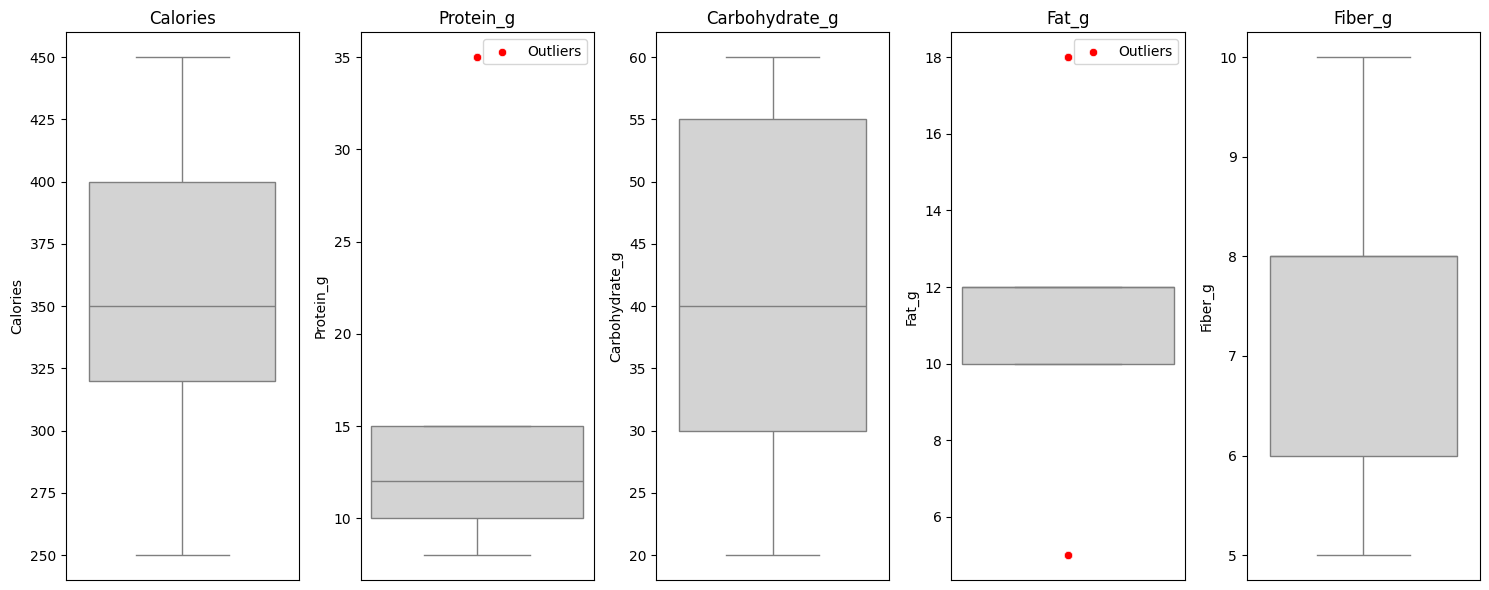

In [82]:
plt.figure(figsize=(15, 6))

for i, col in enumerate(num_cols, 1):
    Q1 = meals_df[col].quantile(0.25)
    Q3 = meals_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = meals_df[(meals_df[col] < lower_bound) | (meals_df[col] > upper_bound)]

    plt.subplot(1, len(num_cols), i)
    sns.boxplot(y=meals_df[col], color='lightgray', fliersize=0)
    sns.scatterplot(y=outliers[col], x=[0]*len(outliers), color='red', label='Outliers')
    plt.title(f"{col}")
    plt.ylabel(col)
    plt.xticks([])

plt.tight_layout()
plt.show()

##**FIS Creation, GA, Streamlit Tabs**##

In [83]:
%%writefile app_final_3.py
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

meals_df = pd.read_csv("meal.csv")
meal_ids = meals_df["Meal_ID"].tolist()

# ----------------------
# Fuzzy Logic Functions
# ----------------------

## a) Creation of Membership Functions

def triangular(x, a, b, c):
    """Triangular membership function."""
    return np.maximum(np.minimum((x - a) / (b - a), (c - x) / (c - b)), 0)

def age_membership(age):
    return {
        "Young": triangular(age, 18, 20, 25),
        "Adult": triangular(age, 30, 35, 45),
        "Elder": triangular(age, 50, 55, 60)
    }

def bmi_membership(bmi):
    return {
        "Underweight": triangular(bmi, 0, 16, 18.5),
        "Normal": triangular(bmi, 18, 22, 25),
        "Overweight": triangular(bmi, 23, 27, 30),
        "Obese": triangular(bmi, 28, 35, 50)
    }

def activity_membership(activity_level):
    return {
        "Low": triangular(activity_level, 1, 2, 4),
        "Moderate": triangular(activity_level, 3, 5, 7),
        "High": triangular(activity_level, 6, 8, 10)
    }

## These membership functions determine the degree to which an input (age, BMI, activity level)
## belongs to each fuzzy category.

def fuzzy_health_assessment(age, bmi, activity, diabetes=False, hypertension=False):
    risk_category = None

    age_m = age_membership(age)
    bmi_m = bmi_membership(bmi)
    act_m = activity_membership(activity)

    # Rule: BMI Obese & Diabetes => High Risk
    if bmi >= 30 and diabetes:
        risk_category = "High"

    # Rule: BMI Obese & Activity Low & Hypertension => High Risk
    if bmi >= 30 and activity <= 3 and hypertension:
        risk_category = "High"

    # Rule: Age Elder & Normal BMI & Moderate Activity => Medium Risk
    if age >= 60 and 18.5 <= bmi <= 24.9 and 3 < activity <= 7:
        risk_category = "Moderate"

    # Rule: Age Young & Diabetes => Medium Risk
    if age < 30 and diabetes:
        risk_category = "Moderate"

    # Rule: Underweight & Activity High => Low to Medium Risk
    if bmi < 18.5 and activity >= 7:
        risk_category = "Moderate"

    # Fallback to fuzzy logic computation if not overridden
    if risk_category is None:
        age_risk = {"Young": 0, "Adult": 25, "Elder": 60}
        bmi_risk = {"Underweight": 18, "Normal": 22, "Overweight": 27, "Obese": 40}
        act_risk = {"Low": 80, "Moderate": 50, "High": 20}

        age_risk_val = sum(age_m[cat] * age_risk[cat] for cat in age_m) / (sum(age_m.values()) + 1e-6)
        bmi_risk_val = sum(bmi_m[cat] * bmi_risk[cat] for cat in bmi_m) / (sum(bmi_m.values()) + 1e-6)
        act_risk_val = sum(act_m[cat] * act_risk[cat] for cat in act_m) / (sum(act_m.values()) + 1e-6)

        risk_score = (age_risk_val + bmi_risk_val + act_risk_val) / 3
        if diabetes:
            risk_score += 5
        if hypertension:
            risk_score += 3
        risk_score = np.clip(risk_score, 0, 100)

        if risk_score < 35:
            risk_category = "Low"
        elif risk_score < 60:
            risk_category = "Moderate"
        else:
            risk_category = "High"

    return risk_category

# Get_recommendations to use new rules
def get_recommendations(age, bmi, activity, diabetes, hypertension, risk_category):
    recommendations = {}

    if risk_category == "High" and diabetes:
        recommendations["Carbs"] = "Low"
        recommendations["Sugar"] = "Low"

    if risk_category == "Medium" and hypertension:
        recommendations["Sodium"] = "Low"
        recommendations["Potassium"] = "High"

    if risk_category == "Low" and age >= 60:
        recommendations["Calcium"] = "High"

    if risk_category == "Medium" and age >= 60:
        recommendations["Fiber"] = "High"

    if risk_category == "High" and activity >= 7:
        recommendations["Protein"] = "High"

    if risk_category == "Medium" and bmi >= 25:
        recommendations["Calories"] = "Moderate"
        recommendations["Fat"] = "Moderate"

    if risk_category == "Low" and bmi < 18.5:
        recommendations["Calories"] = "Moderate"
        recommendations["Protein"] = "Moderate"

    if bmi < 18.5 and activity <= 3:
        risk_category = "Moderate"

    if age >= 60 and (diabetes or hypertension):
        risk_category = "High"

# Fallbacks
    if "Calories" not in recommendations:
       recommendations["Calories"] = {
        "High": 1500,
        "Medium": 2000,
        "Low": 2500
    }.get(risk_category, 2000)

    if "Protein" not in recommendations:
        recommendations["Protein"] = {
        "High": "High",
        "Medium": "Moderate",
        "Low": "Moderate"
    }.get(risk_category, "Moderate")  # default to Moderate

    if "Fat" not in recommendations:
       recommendations["Fat"] = {
        "High": "Low",
        "Medium": "Moderate",
        "Low": "Moderate"
    }.get(risk_category, "Moderate")  # default to Moderate

    if "Carbs" not in recommendations:
      recommendations["Carbs"] = {
        "High": "Moderate",
        "Medium": "Moderate",
        "Low": "High"
    }.get(risk_category, "Moderate")  # default to Moderate


    return recommendations


# ---------------------------------
# Genetic Algorithm (GA) Functions
# ---------------------------------
POPULATION_SIZE = 500
NUM_DAYS = 7
MEALS_PER_DAY = 3
CHROMOSOME_LENGTH = NUM_DAYS * MEALS_PER_DAY
GENERATIONS = 50
TARGET_CALORIES = 2100

w_macro = 0.5
w_variety = 0.3
w_allergy = 0.2

def fitness_function(chromosome, high_protein=True):
    plan = meals_df[meals_df["Meal_ID"].isin(chromosome)]
    total_calories = plan["Calories"].sum()
    target_weekly = TARGET_CALORIES * 7
    macro_diff_score = abs(target_weekly - total_calories)
    variety_score = CHROMOSOME_LENGTH - len(set(chromosome))

    penalty = 0
    protein_total = plan["Protein_g"].sum()
    avg_protein = protein_total / CHROMOSOME_LENGTH
    if high_protein:
        if avg_protein < 10:
            penalty += (10 - avg_protein) * 100
        else:
            penalty -= 50

    return w_macro * macro_diff_score + w_variety * variety_score + w_allergy * penalty

def create_chromosome():
    return [random.choice(meal_ids) for _ in range(CHROMOSOME_LENGTH)]

def tournament_selection(population, k=3, high_protein=True):
    selected = random.sample(population, k)
    selected.sort(key=lambda chromo: fitness_function(chromo, high_protein))
    return selected[0]

def crossover(parent1, parent2):
    day = random.randint(0, NUM_DAYS - 1)
    start = day * MEALS_PER_DAY
    end = start + MEALS_PER_DAY
    child1 = parent1.copy()
    child2 = parent2.copy()
    child1[start:end], child2[start:end] = parent2[start:end], parent1[start:end]
    return child1, child2

def mutate(chromosome, mutation_rate=0.15):
    new_chromosome = chromosome.copy()
    for i in range(CHROMOSOME_LENGTH):
        if random.random() < mutation_rate:
            new_chromosome[i] = random.choice(meal_ids)
    return new_chromosome

# Use session state to store GA results so that changing the selectbox doesn't rerun the GA.
if "ga_result" not in st.session_state:
    st.session_state.ga_result = None
    st.session_state.fitness_history = None

def run_ga(high_protein=True):
    population = [create_chromosome() for _ in range(POPULATION_SIZE)]
    best_chromo = None
    best_fit = float('inf')
    fitness_history = []
    for generation in range(GENERATIONS):
        new_population = []
        population.sort(key=lambda chromo: fitness_function(chromo, high_protein))
        new_population.extend(population[:2])
        while len(new_population) < POPULATION_SIZE:
            parent1 = tournament_selection(population, high_protein=high_protein)
            parent2 = tournament_selection(population, high_protein=high_protein)
            child1, child2 = crossover(parent1, parent2)
            child1 = mutate(child1, mutation_rate=0.15)
            child2 = mutate(child2, mutation_rate=0.15)
            new_population.extend([child1, child2])
        population = new_population[:POPULATION_SIZE]
        current_best = min(population, key=lambda chromo: fitness_function(chromo, high_protein))
        current_fit = fitness_function(current_best, high_protein)
        if current_fit < best_fit:
            best_fit = current_fit
            best_chromo = current_best
        fitness_history.append(best_fit)
    return best_chromo, fitness_history


# -------------------------------
# Streamlit App Layout with Tabs
# -------------------------------

st.set_page_config(page_title="Fuzzy-GA Diet Planner", layout="wide")
st.title("Smart Diet Plan Recommendation Using Fuzzy-GA")

with st.sidebar:
    st.title("Fuzzy-GA Diet Recommendation")
    st.markdown(
        """
        **About:**
        This app uses fuzzy logic to assess your health risk based on your Age, BMI and Activity Level.
        It then provides personalized nutrient recommendations and uses a genetic algorithm (GA)
        to generate an optimized weekly meal plan which suited to your dietary preferences.
        """
    )

# Tabs for Navigation
tabs = st.tabs(["Overview", "Health Assessment", "Meal Plan Optimization", "Membership Functions"])

# ----------------------------
# Tab 1: Overview
# ----------------------------
with tabs[0]:
    st.header("Overview")
    st.markdown(
        """
        **Smart Diet Plan Recommendation** integrates:
        - A **Fuzzy Logic** to evaluate your health risk and provide nutrient recommendations.
        - A **Genetic Algorithm** to optimize a weekly meal plan that fits your nutritional needs and dietary preferences.

        Use the tabs to explore:
        - Your health assessment based on your inputs.
        - The optimized meal plan and detailed nutrient breakdowns.
        - Interactive membership function plots that explain the fuzzy logic.
        """
    )

# ----------------------------
# Tab 2: Health Assessment
# ----------------------------
with tabs[1]:
    st.header("Health Assessment")
    col1, col2 = st.columns(2)
    with col1:
        st.subheader("Enter Your Health Details")
        user_age = st.number_input("Age", min_value=18, max_value=60, value=25, key="age")
        user_bmi = st.number_input("BMI", min_value=10.0, max_value=50.0, value=22.0, step=0.1, key="bmi")
        user_activity = st.slider("Activity Level (1 low - 10 high)", 1, 10, 5, key="activity")
        user_diabetes = st.checkbox("Diabetes", value=False, key="diabetes")
        user_hypertension = st.checkbox("Hypertension", value=False, key="hypertension")
    with col2:
        risk, risk_cat, fuzzy_expl = fuzzy_health_assessment(user_age, user_bmi, user_activity, user_diabetes, user_hypertension)
        recs = get_recommendations(user_age, user_bmi, user_activity, user_diabetes, user_hypertension, risk_cat)
        st.subheader("Your Health Summary")
        st.markdown(f"**Risk Category:** {risk_cat}")
        st.markdown("**Nutrient Recommendations:**")
        st.write(recs)
    st.markdown("---")
    st.markdown("**Fuzzy Logic Explanation:**")
    st.json(fuzzy_expl)

# ----------------------------
# Tab 3: Meal Plan Optimization
# ----------------------------
with tabs[2]:
    st.header("Meal Plan Optimization")
    st.markdown("Click the button below to generate an optimized weekly meal plan focusing on high protein intake.")

    # Check if GA result is stored in session_state; if not, run GA when button clicked.
    if st.button("Generate Meal Plan"):
        with st.spinner("Optimizing your meal plan..."):
            best_plan, fitness_history = run_ga(high_protein=True)
            st.session_state.ga_result = best_plan
            st.session_state.fitness_history = fitness_history
        st.success("Meal plan generated!")

    if st.session_state.ga_result is not None:
        # GA Evolution Chart
        st.subheader("GA Evolution")
        fig_ga, ax_ga = plt.subplots(figsize=(8, 4))
        ax_ga.plot(st.session_state.fitness_history, marker='o', linestyle='-')
        ax_ga.set_xlabel("Generation")
        ax_ga.set_ylabel("Best Fitness")
        ax_ga.set_title("GA Evolution: Fitness over Generations")
        st.pyplot(fig_ga)

        # Convert Meal_IDs to "ID - Meal Name"
        meal_names = []
        for meal_id in st.session_state.ga_result:
            meal_row = meals_df[meals_df["Meal_ID"] == meal_id]
            if not meal_row.empty:
                name = meal_row.iloc[0]["Meal_Name"]
                meal_names.append(f"{meal_id} - {name}")
            else:
                meal_names.append(f"{meal_id} - Unknown")

        # Build weekly plan DataFrame with meal names
        plan_df_named = pd.DataFrame(
            np.array(meal_names).reshape(NUM_DAYS, MEALS_PER_DAY),
            columns=["Meal 1", "Meal 2", "Meal 3"]
        )
        st.subheader("Optimized Weekly Meal Plan")
        st.dataframe(plan_df_named)

        # Daily Nutrient Totals
        daily_totals = []
        for day in range(NUM_DAYS):
            day_ids = st.session_state.ga_result[day*MEALS_PER_DAY:(day+1)*MEALS_PER_DAY]
            day_plan = meals_df[meals_df["Meal_ID"].isin(day_ids)]
            totals = {
                "Calories": day_plan["Calories"].sum(),
                "Protein": day_plan["Protein_g"].sum(),
                "Carbohydrates": day_plan["Carbohydrate_g"].sum(),
                "Fat": day_plan["Fat_g"].sum(),
                "Fiber": day_plan["Fiber_g"].sum()
            }
            daily_totals.append(totals)
        daily_df = pd.DataFrame(daily_totals)
        st.subheader("Daily Nutrient Totals")
        st.dataframe(daily_df)

        # Interactive Meal Nutrient Breakdown
        st.subheader("View Meal Nutrient Breakdown")
        meal_choice = st.selectbox("Select a Meal ID from the Optimized Plan", sorted(set(st.session_state.ga_result)), key="meal_select")
        selected_meal = meals_df[meals_df["Meal_ID"] == meal_choice].iloc[0]
        fig_meal, ax_meal = plt.subplots(figsize=(8, 4))
        meal_nutrients = ["Calories", "Protein_g", "Carbohydrate_g", "Fat_g", "Fiber_g"]
        nutrient_values = [selected_meal[n] for n in meal_nutrients]
        ax_meal.bar(meal_nutrients, nutrient_values, color="skyblue")
        ax_meal.set_ylabel("Value")
        ax_meal.set_title(f"Nutrient Breakdown: {selected_meal['Meal_Name']}")
        st.pyplot(fig_meal)
    else:
        st.info("Click 'Generate Meal Plan' to optimize your weekly meal plan.")

# ----------------------------
# Tab 4: Membership Functions
# ----------------------------
with tabs[3]:
    st.header("Membership Function Plots")
    st.markdown("These plots illustrate the membership functions used for Age, BMI and Activity.")

    st.subheader("Age Membership Functions")
    x_age = np.linspace(0, 100, 500)
    fig_age, ax_age = plt.subplots(figsize=(8, 4))
    ax_age.plot(x_age, [age_membership(x)["Young"] for x in x_age], label="Young")
    ax_age.plot(x_age, [age_membership(x)["Adult"] for x in x_age], label="Adult")
    ax_age.plot(x_age, [age_membership(x)["Elder"] for x in x_age], label="Elder")
    ax_age.set_xlabel("Age")
    ax_age.set_ylabel("Membership Degree")
    ax_age.set_title("Age Membership Functions")
    ax_age.legend()
    st.pyplot(fig_age)

    st.subheader("BMI Membership Functions")
    x_bmi = np.linspace(0, 50, 500)
    fig_bmi, ax_bmi = plt.subplots(figsize=(8, 4))
    ax_bmi.plot(x_bmi, [bmi_membership(x)["Underweight"] for x in x_bmi], label="Underweight")
    ax_bmi.plot(x_bmi, [bmi_membership(x)["Normal"] for x in x_bmi], label="Normal")
    ax_bmi.plot(x_bmi, [bmi_membership(x)["Overweight"] for x in x_bmi], label="Overweight")
    ax_bmi.plot(x_bmi, [bmi_membership(x)["Obese"] for x in x_bmi], label="Obese")
    ax_bmi.set_xlabel("BMI")
    ax_bmi.set_ylabel("Membership Degree")
    ax_bmi.set_title("BMI Membership Functions")
    ax_bmi.legend()
    st.pyplot(fig_bmi)

    st.subheader("Activity Membership Functions")
    x_act = np.linspace(0, 10, 500)
    fig_act, ax_act = plt.subplots(figsize=(8, 4))
    ax_act.plot(x_act, [activity_membership(x)["Low"] for x in x_act], label="Low")
    ax_act.plot(x_act, [activity_membership(x)["Moderate"] for x in x_act], label="Moderate")
    ax_act.plot(x_act, [activity_membership(x)["High"] for x in x_act], label="High")
    ax_act.set_xlabel("Activity Level")
    ax_act.set_ylabel("Membership Degree")
    ax_act.set_title("Activity Membership Functions")
    ax_act.legend()
    st.pyplot(fig_act)

Overwriting app_final_3.py
